## Kerasによる銀河形態分類（Hubble系列8クラス）畳み込みニューラルネット  
### Chollet, F. (2018). *Deep Learning with Python.* Manning Publications Co. Chapter 5参照


In [1]:
import os, shutil
import sys, time
import keras
print(keras.__version__)

# 作業用ディレクトリ定義（要カスタマイズ）
galaxy_data_directory = '/home/satoshi/Galaxy/'

Using TensorFlow backend.


2.2.0


#### Keras Conv2Dモデル  input_shape;150

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### モデルのコンパイル

In [3]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

#### イメージデータジェネレータ(Data augmentationあり)
#### 制約データセット　dataset_8class_limited_256_01

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator用訓練データディレクトリ
train_generator_directory = galaxy_data_directory + 'train'
# ImageDataGenerator用検証データディレクトリ
validation_generator_directory = galaxy_data_directory + 'validation'
# ImageDataGenerator用テストデータディレクトリ
test_generator_directory = galaxy_data_directory + 'test'

# 訓練データのaugmentation　
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,   # 40 => 60
    width_shift_range=0.2,
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, )
    
# 訓練データジェネレータ　バッチサイズ：　40
train_generator = train_datagen.flow_from_directory(
        train_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(train_generator.class_indices)

# 検証データジェネレータ　バッチサイズ：　40
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(validation_generator.class_indices)

# テストデータジェネレータ　バッチサイズ：　40
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_generator_directory,
        target_size=(150, 150),
        batch_size=40,
        class_mode='categorical')
print(test_generator.class_indices)

Found 3200 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
Found 3200 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
Found 3200 images belonging to 8 classes.
{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}


#### モデルの学習

In [5]:
# 学習　エポック数：　300
history = model.fit_generator(
        train_generator,
        # 訓練データ件数8x400=3200, バッチサイズ40 => 3200/40=80 steps/epoch
        steps_per_epoch=80,  
        epochs=300,
        # 検証データ件数8x400=3200, バッチサイズ40 => 3200/40=800 steps/epoch
        validation_data=validation_generator,
        validation_steps=80)

Epoch 1/300
80/80 [==============================] - 20s 245ms/step - loss: 1.8644 - acc: 0.2059 - val_loss: 1.5712 - val_acc: 0.2787
Epoch 2/300
80/80 [==============================] - 17s 214ms/step - loss: 1.6165 - acc: 0.2919 - val_loss: 1.5645 - val_acc: 0.2616
Epoch 3/300
80/80 [==============================] - 17s 216ms/step - loss: 1.5679 - acc: 0.3159 - val_loss: 1.4470 - val_acc: 0.3275
Epoch 4/300
80/80 [==============================] - 18s 219ms/step - loss: 1.5502 - acc: 0.3225 - val_loss: 1.4227 - val_acc: 0.3903
Epoch 5/300
80/80 [==============================] - 17s 217ms/step - loss: 1.5208 - acc: 0.3338 - val_loss: 1.4863 - val_acc: 0.3416
Epoch 6/300
80/80 [==============================] - 17s 213ms/step - loss: 1.5047 - acc: 0.3537 - val_loss: 1.3823 - val_acc: 0.3884
Epoch 7/300
80/80 [==============================] - 17s 214ms/step - loss: 1.4846 - acc: 0.3588 - val_loss: 1.3790 - val_acc: 0.4178
Epoch 8/300
80/80 [==============================] - 17s 218ms

Epoch 62/300
80/80 [==============================] - 17s 216ms/step - loss: 1.0900 - acc: 0.5459 - val_loss: 1.1087 - val_acc: 0.5194
Epoch 63/300
80/80 [==============================] - 18s 221ms/step - loss: 1.0900 - acc: 0.5406 - val_loss: 1.0089 - val_acc: 0.5672
Epoch 64/300
80/80 [==============================] - 17s 215ms/step - loss: 1.1021 - acc: 0.5306 - val_loss: 0.9933 - val_acc: 0.5737
Epoch 65/300
80/80 [==============================] - 17s 213ms/step - loss: 1.0951 - acc: 0.5406 - val_loss: 0.9939 - val_acc: 0.5850
Epoch 66/300
80/80 [==============================] - 17s 216ms/step - loss: 1.0722 - acc: 0.5509 - val_loss: 0.9909 - val_acc: 0.5897
Epoch 67/300
80/80 [==============================] - 18s 221ms/step - loss: 1.0742 - acc: 0.5466 - val_loss: 0.9985 - val_acc: 0.5706
Epoch 68/300
80/80 [==============================] - 17s 213ms/step - loss: 1.0628 - acc: 0.5506 - val_loss: 0.9885 - val_acc: 0.5828
Epoch 69/300
80/80 [==============================] - 1

80/80 [==============================] - 17s 215ms/step - loss: 0.9015 - acc: 0.6387 - val_loss: 0.8716 - val_acc: 0.6488
Epoch 183/300
80/80 [==============================] - 17s 215ms/step - loss: 0.8988 - acc: 0.6409 - val_loss: 0.8919 - val_acc: 0.6387
Epoch 184/300
80/80 [==============================] - 17s 214ms/step - loss: 0.8822 - acc: 0.6431 - val_loss: 0.9004 - val_acc: 0.6372
Epoch 185/300
80/80 [==============================] - 17s 215ms/step - loss: 0.8795 - acc: 0.6416 - val_loss: 0.8840 - val_acc: 0.6487
Epoch 186/300
80/80 [==============================] - 18s 224ms/step - loss: 0.8817 - acc: 0.6425 - val_loss: 0.9007 - val_acc: 0.6544
Epoch 187/300
80/80 [==============================] - 17s 213ms/step - loss: 0.8749 - acc: 0.6494 - val_loss: 0.8785 - val_acc: 0.6525
Epoch 188/300
80/80 [==============================] - 17s 218ms/step - loss: 0.8902 - acc: 0.6466 - val_loss: 0.8655 - val_acc: 0.6619
Epoch 189/300
80/80 [==============================] - 17s 215

In [6]:
# モデルの退避
model.save(galaxy_data_directory + 'galaxy_cnn_8class_256px_sf01_limited_model.h5')

#### 学習履歴のビジュアル化

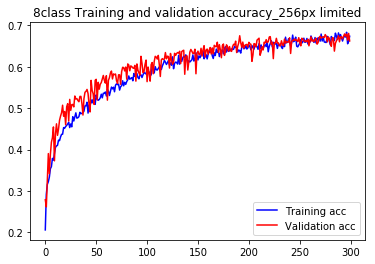

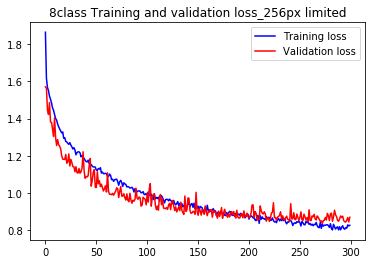

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('8class Training and validation accuracy_256px limited')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('8class Training and validation loss_256px limited')
plt.legend()

plt.show()

#### テストデータセットによる精度評価

In [8]:
metric = model.evaluate_generator(test_generator)
print('Test loss = ', metric[0])
print('Test acc  = ', metric[1])

Test loss =  0.8559277094900608
Test acc  =  0.667187500372529


#### テストデータセットからサンプリングした銀河イメージデータについての形態クラス予測結果

{'E0': 0, 'E3': 1, 'E7': 2, 'Edgeon': 3, 'S0': 4, 'SB0': 5, 'SBabc': 6, 'Sabc': 7}
E0_6_12_46_587728879806316644.jpeg
E0 : 66%   E3 : 32%   E7 : 0%   S0 : 0%   SBabc : 0%   SB0 : 0%   Sabc : 0%   Edgeon : 0%   


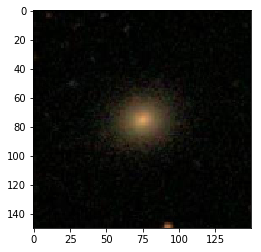

E0_6_11_45_587742061078380705.jpeg
E0 : 69%   E3 : 29%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


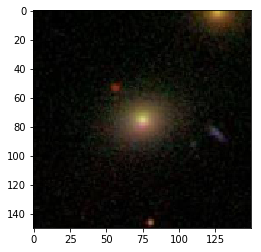

E0_6_5_56_588010879833735336.jpeg
E0 : 82%   E3 : 17%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


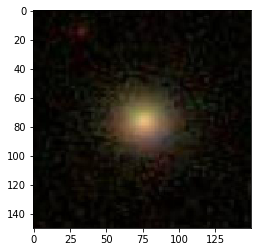

E0_5_10_49_587739811557539992.jpeg
E0 : 85%   E3 : 14%   E7 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


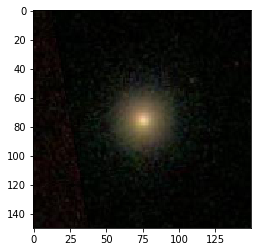

E0_6_6_42_588007004157968699.jpeg
E0 : 76%   E3 : 23%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


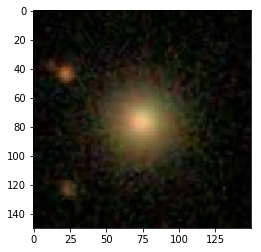

E0_6_5_55_587727866718912858.jpeg
E3 : 55%   E0 : 43%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


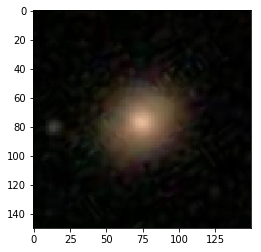

E0_6_5_58_587742552288264340.jpeg
E0 : 63%   E3 : 36%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


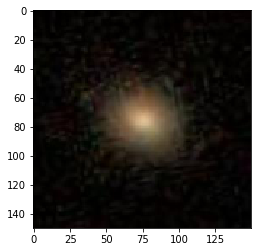

E0_2_18_43_587736802936356904.jpeg
E0 : 82%   E3 : 17%   S0 : 0%   E7 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


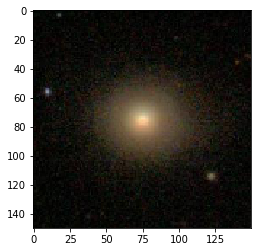

E0_7_5_49_587729747912556811.jpeg
E0 : 87%   E3 : 12%   S0 : 0%   E7 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


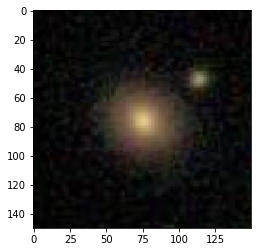

E0_6_8_32_588017947735818275.jpeg
E0 : 69%   S0 : 14%   E3 : 12%   SB0 : 2%   Sabc : 0%   SBabc : 0%   E7 : 0%   Edgeon : 0%   


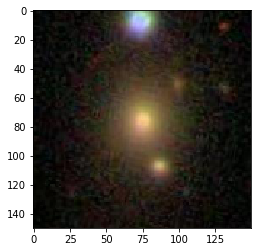

E3_6_6_45_587733080272928900.jpeg
E3 : 88%   E7 : 10%   E0 : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   SBabc : 0%   Edgeon : 0%   


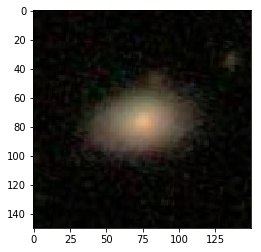

E3_2_8_58_587730021723799902.jpeg
E3 : 53%   E0 : 46%   E7 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


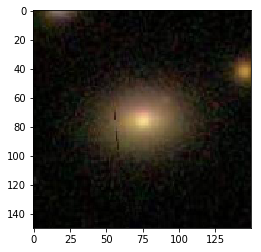

E3_7_4_53_587731187283722363.jpeg
E3 : 55%   E7 : 43%   E0 : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   Edgeon : 0%   SBabc : 0%   


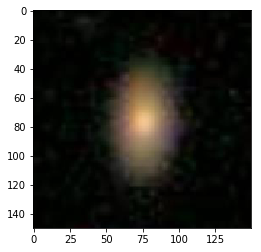

E3_7_6_40_588016879367880934.jpeg
E3 : 76%   E7 : 20%   E0 : 2%   S0 : 0%   SB0 : 0%   SBabc : 0%   Sabc : 0%   Edgeon : 0%   


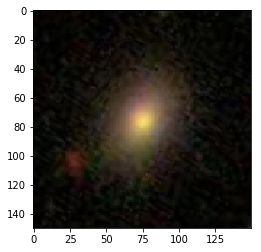

E3_7_4_49_588018055130186241.jpeg
E3 : 73%   E7 : 26%   E0 : 0%   S0 : 0%   SB0 : 0%   SBabc : 0%   Sabc : 0%   Edgeon : 0%   


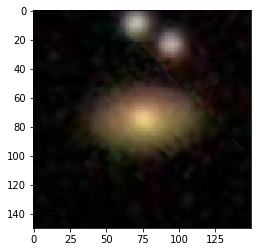

E3_6_17_22_587726015079252142.jpeg
E0 : 62%   E3 : 35%   E7 : 1%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


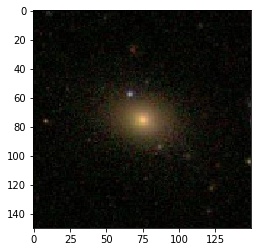

E3_2_25_38_587739707946893407.jpeg
E3 : 74%   E0 : 20%   E7 : 4%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   Edgeon : 0%   


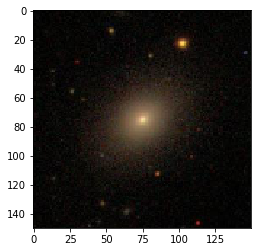

E3_6_8_43_587729158971719862.jpeg
E3 : 78%   E7 : 12%   E0 : 9%   S0 : 0%   SBabc : 0%   Sabc : 0%   SB0 : 0%   Edgeon : 0%   


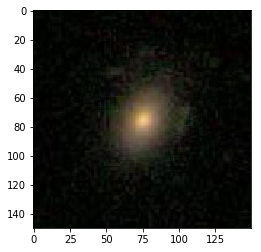

E3_7_5_52_587742775088644296.jpeg
E0 : 99%   S0 : 0%   E3 : 0%   Sabc : 0%   E7 : 0%   SBabc : 0%   SB0 : 0%   Edgeon : 0%   


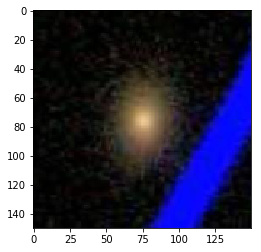

E3_4_5_56_588013382199607443.jpeg
E3 : 55%   E7 : 44%   E0 : 0%   S0 : 0%   SB0 : 0%   Edgeon : 0%   Sabc : 0%   SBabc : 0%   


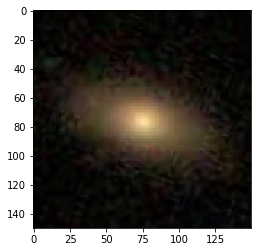

E7_7_5_47_588013383792591348.jpeg
E7 : 99%   Edgeon : 0%   E3 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   SB0 : 0%   E0 : 0%   


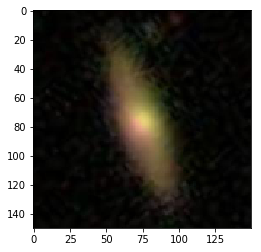

E7_2_13_53_587735696985948186.jpeg
E7 : 97%   E3 : 2%   Edgeon : 0%   SBabc : 0%   S0 : 0%   Sabc : 0%   SB0 : 0%   E0 : 0%   


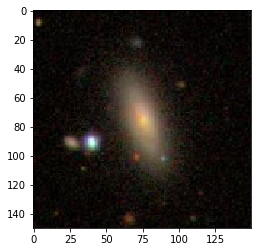

E7_4_8_45_587732772670210099.jpeg
E7 : 99%   E3 : 0%   Edgeon : 0%   SB0 : 0%   S0 : 0%   SBabc : 0%   Sabc : 0%   E0 : 0%   


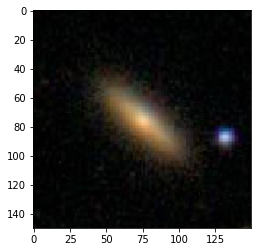

E7_6_6_52_587738195576750318.jpeg
E7 : 87%   E3 : 12%   Edgeon : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   SBabc : 0%   E0 : 0%   


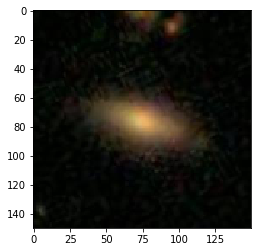

E7_7_4_58_587734863216509110.jpeg
E7 : 87%   E3 : 12%   Edgeon : 0%   S0 : 0%   SB0 : 0%   Sabc : 0%   E0 : 0%   SBabc : 0%   


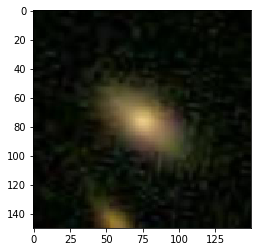

E7_4_8_46_587731186734072010.jpeg
E7 : 77%   E3 : 22%   Edgeon : 0%   SB0 : 0%   E0 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   


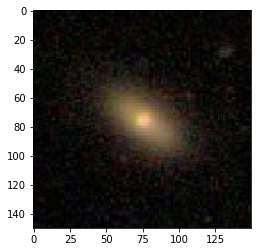

E7_5_6_50_587739132965093522.jpeg
E7 : 97%   E3 : 2%   Edgeon : 0%   S0 : 0%   SB0 : 0%   SBabc : 0%   Sabc : 0%   E0 : 0%   


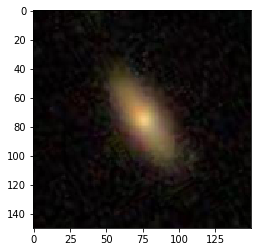

E7_7_4_51_588013382191087989.jpeg
E7 : 83%   E3 : 16%   E0 : 0%   S0 : 0%   Edgeon : 0%   SB0 : 0%   SBabc : 0%   Sabc : 0%   


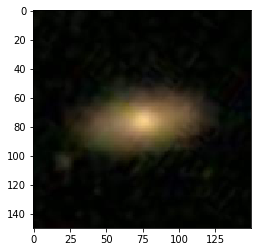

E7_4_10_36_587726033303830689.jpeg
E7 : 98%   E3 : 1%   Edgeon : 0%   SB0 : 0%   S0 : 0%   Sabc : 0%   SBabc : 0%   E0 : 0%   


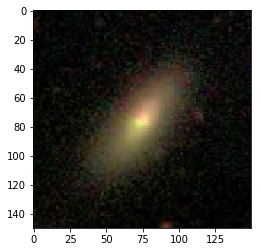

E7_4_6_54_587739809420869676.jpeg
SB0 : 40%   Edgeon : 26%   E3 : 13%   E7 : 12%   S0 : 3%   SBabc : 3%   Sabc : 0%   E0 : 0%   


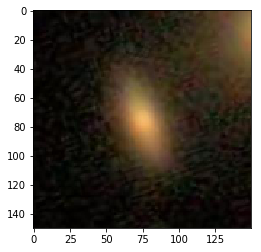

Edgeon_6_3_54_587726032796647547.jpeg
Edgeon : 91%   SB0 : 4%   S0 : 3%   Sabc : 0%   SBabc : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


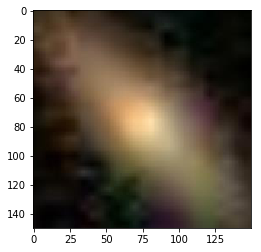

Edgeon_3_15_34_588010135191093287.jpeg
SB0 : 41%   Edgeon : 37%   S0 : 9%   SBabc : 8%   Sabc : 3%   E7 : 0%   E3 : 0%   E0 : 0%   


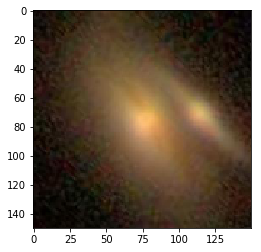

Edgeon_5_12_51_587738564946624750.jpeg
Edgeon : 98%   SBabc : 0%   Sabc : 0%   S0 : 0%   SB0 : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


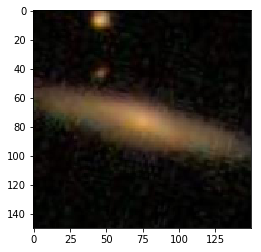

Edgeon_4_9_46_587731522273214478.jpeg
Edgeon : 70%   SB0 : 15%   S0 : 6%   Sabc : 3%   SBabc : 2%   E7 : 0%   E3 : 0%   E0 : 0%   


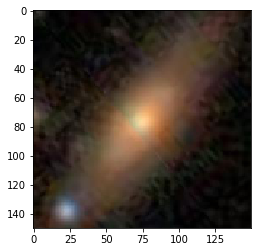

Edgeon_5_6_50_588017567634161786.jpeg
Edgeon : 41%   SB0 : 37%   SBabc : 8%   S0 : 7%   Sabc : 6%   E7 : 0%   E3 : 0%   E0 : 0%   


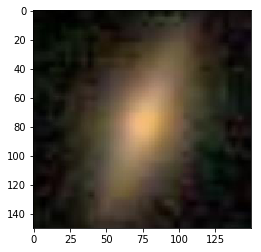

Edgeon_6_5_52_587731873923662225.jpeg
Edgeon : 95%   SB0 : 2%   S0 : 1%   Sabc : 0%   SBabc : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


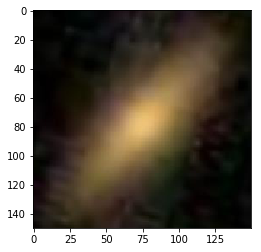

Edgeon_7_8_51_587731187274743977.jpeg
Edgeon : 94%   SB0 : 2%   SBabc : 1%   S0 : 0%   Sabc : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


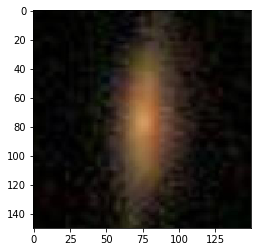

Edgeon_6_4_60_588011122506203229.jpeg
Edgeon : 69%   SB0 : 16%   S0 : 8%   Sabc : 4%   SBabc : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


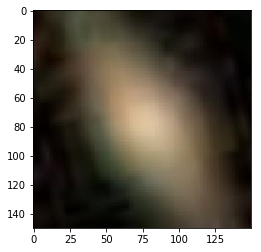

Edgeon_4_4_60_587735346952667209.jpeg
Edgeon : 82%   SB0 : 14%   S0 : 2%   Sabc : 0%   SBabc : 0%   E7 : 0%   E3 : 0%   E0 : 0%   


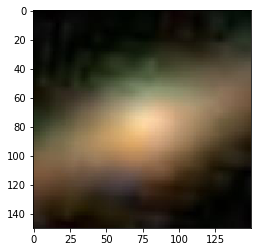

Edgeon_6_6_58_587738411398922357.jpeg
SB0 : 26%   Edgeon : 25%   SBabc : 18%   S0 : 17%   Sabc : 12%   E7 : 0%   E3 : 0%   E0 : 0%   


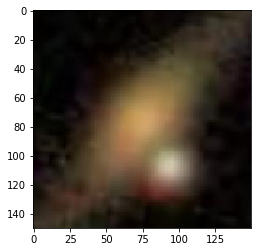

S0_6_7_52_587731512611569858.jpeg
SB0 : 33%   Sabc : 22%   S0 : 17%   SBabc : 13%   Edgeon : 9%   E7 : 1%   E3 : 0%   E0 : 0%   


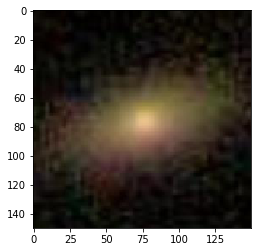

S0_5_8_57_588295840708624519.jpeg
S0 : 47%   Sabc : 25%   SBabc : 14%   SB0 : 10%   E0 : 1%   Edgeon : 0%   E3 : 0%   E7 : 0%   


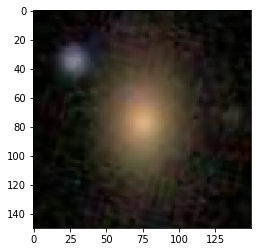

S0_6_5_53_587739303679230060.jpeg
SBabc : 41%   Sabc : 33%   SB0 : 14%   S0 : 9%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


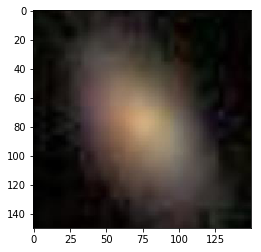

S0_5_8_56_587731521201504267.jpeg
SB0 : 60%   S0 : 30%   Edgeon : 4%   SBabc : 1%   Sabc : 1%   E3 : 1%   E0 : 0%   E7 : 0%   


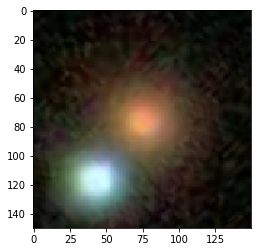

S0_5_9_38_587742552289312927.jpeg
S0 : 67%   SB0 : 19%   Sabc : 7%   SBabc : 4%   E0 : 0%   Edgeon : 0%   E3 : 0%   E7 : 0%   


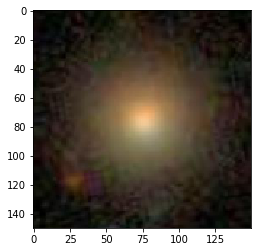

S0_7_4_49_588015509829517446.jpeg
SB0 : 35%   S0 : 31%   Edgeon : 27%   Sabc : 2%   SBabc : 2%   E3 : 0%   E7 : 0%   E0 : 0%   


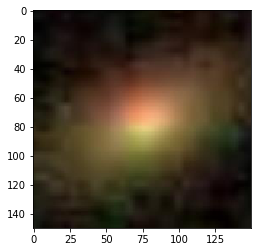

S0_2_8_59_587726100955660660.jpeg
Sabc : 53%   Edgeon : 20%   SBabc : 11%   SB0 : 9%   S0 : 4%   E3 : 0%   E7 : 0%   E0 : 0%   


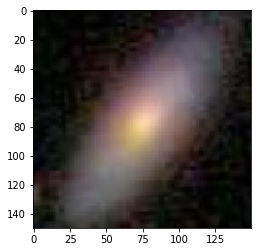

S0_6_7_48_587737808504619176.jpeg
SB0 : 55%   S0 : 27%   SBabc : 10%   Sabc : 4%   Edgeon : 1%   E0 : 0%   E3 : 0%   E7 : 0%   


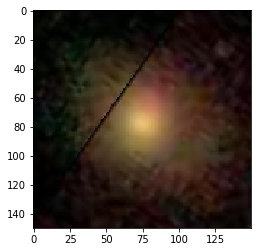

S0_5_9_59_587724648191230074.jpeg
SBabc : 61%   Sabc : 27%   SB0 : 6%   S0 : 4%   Edgeon : 1%   E3 : 0%   E7 : 0%   E0 : 0%   


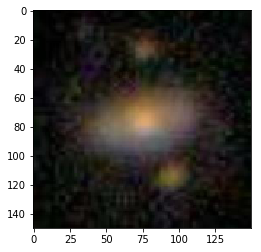

S0_2_13_59_587739844320297336.jpeg
SBabc : 38%   Sabc : 34%   S0 : 15%   SB0 : 11%   Edgeon : 1%   E7 : 0%   E3 : 0%   E0 : 0%   


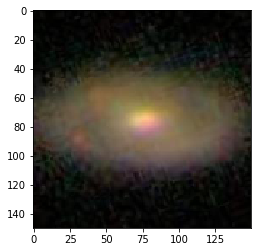

SB0_6_15_34_587733080804884603.jpeg
S0 : 76%   SB0 : 10%   E0 : 7%   Sabc : 3%   SBabc : 0%   E3 : 0%   Edgeon : 0%   E7 : 0%   


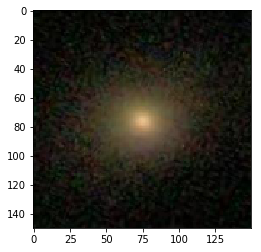

SB0_2_17_47_587725993574924431.jpeg
SBabc : 55%   SB0 : 23%   Sabc : 12%   S0 : 9%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


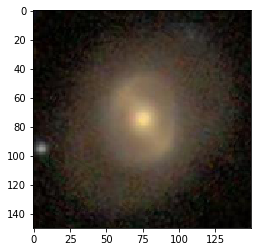

SB0_7_8_48_587725979617591395.jpeg
SB0 : 47%   SBabc : 34%   S0 : 10%   Sabc : 6%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


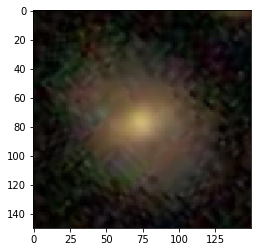

SB0_7_4_53_587741421099024706.jpeg
S0 : 30%   Edgeon : 26%   SB0 : 19%   Sabc : 14%   SBabc : 9%   E7 : 0%   E3 : 0%   E0 : 0%   


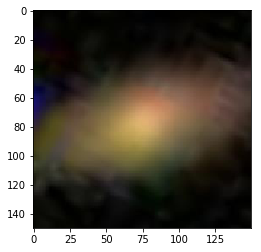

SB0_7_4_54_587736920512659792.jpeg
SB0 : 51%   Edgeon : 36%   S0 : 5%   SBabc : 3%   Sabc : 2%   E7 : 0%   E3 : 0%   E0 : 0%   


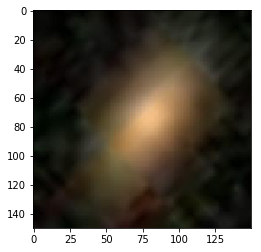

SB0_3_10_50_587736584431337504.jpeg
SB0 : 77%   S0 : 16%   SBabc : 5%   Sabc : 1%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


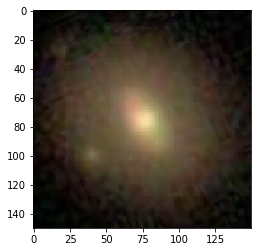

SB0_3_15_54_587739828208468147.jpeg
S0 : 45%   SB0 : 27%   E0 : 16%   Sabc : 4%   E3 : 3%   SBabc : 2%   Edgeon : 0%   E7 : 0%   


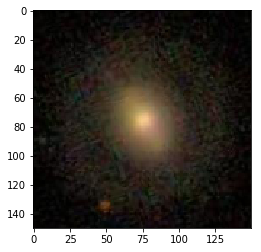

SB0_6_10_45_587745404152643715.jpeg
S0 : 70%   SB0 : 17%   Sabc : 5%   E0 : 2%   SBabc : 2%   E3 : 1%   Edgeon : 0%   E7 : 0%   


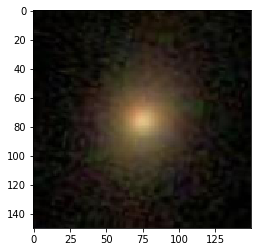

SB0_6_6_56_587736941450428670.jpeg
SB0 : 52%   S0 : 38%   SBabc : 5%   Sabc : 3%   E0 : 0%   E3 : 0%   Edgeon : 0%   E7 : 0%   


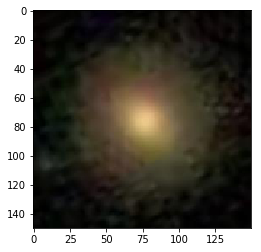

SB0_7_7_34_587742188829606043.jpeg
S0 : 47%   SB0 : 33%   Sabc : 10%   SBabc : 7%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


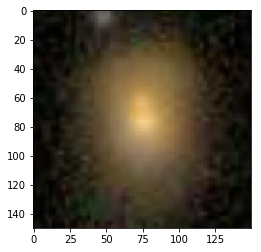

SBabc_4_8_53_587742551215898757.jpeg
SBabc : 26%   Sabc : 25%   S0 : 24%   SB0 : 22%   Edgeon : 1%   E3 : 0%   E7 : 0%   E0 : 0%   


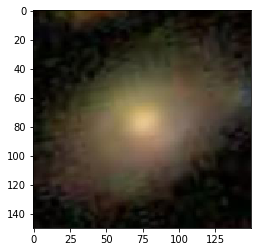

SBabc_5_8_58_588017605756780690.jpeg
SBabc : 53%   Sabc : 44%   S0 : 0%   SB0 : 0%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


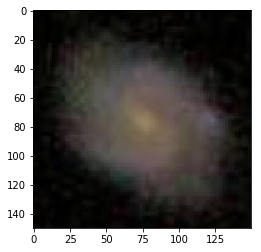

SBabc_6_9_37_587742775093297255.jpeg
Sabc : 72%   SBabc : 19%   SB0 : 3%   S0 : 3%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


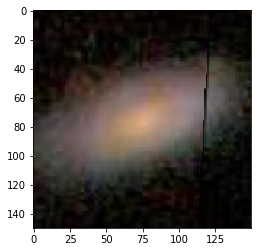

SBabc_7_7_59_587739295088115754.jpeg
SBabc : 56%   Sabc : 42%   S0 : 0%   SB0 : 0%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


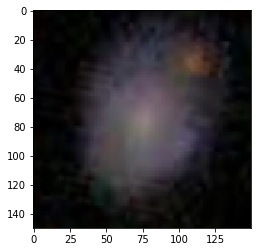

SBabc_4_14_38_587742610802737382.jpeg
SBabc : 69%   Sabc : 30%   SB0 : 0%   S0 : 0%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


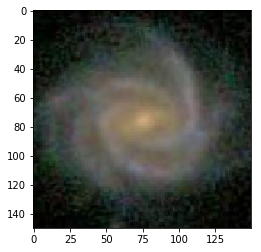

SBabc_7_6_59_587725552816291956.jpeg
SBabc : 71%   Sabc : 27%   S0 : 0%   SB0 : 0%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


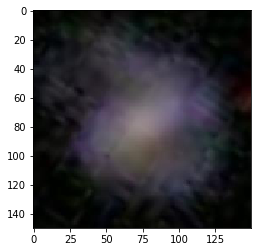

SBabc_6_7_52_587742575904686254.jpeg
SB0 : 27%   Edgeon : 25%   SBabc : 16%   Sabc : 15%   S0 : 14%   E7 : 0%   E3 : 0%   E0 : 0%   


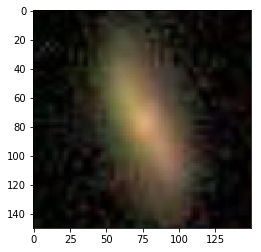

SBabc_6_7_50_587742061623509164.jpeg
SB0 : 65%   S0 : 14%   SBabc : 13%   Sabc : 4%   Edgeon : 1%   E3 : 0%   E7 : 0%   E0 : 0%   


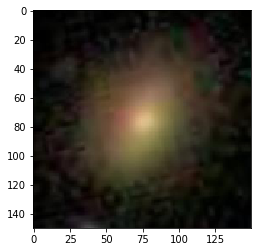

SBabc_5_8_43_588015509277048968.jpeg
SB0 : 59%   S0 : 17%   SBabc : 16%   Sabc : 6%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


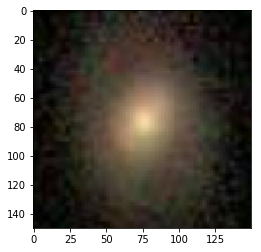

SBabc_3_17_47_587737810645287132.jpeg
Edgeon : 40%   Sabc : 28%   SBabc : 15%   S0 : 9%   SB0 : 5%   E7 : 0%   E3 : 0%   E0 : 0%   


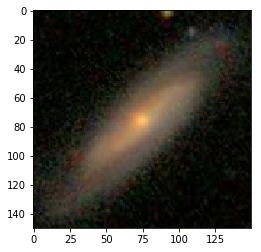

Sabc_6_8_54_587722982284656858.jpeg
SBabc : 61%   Sabc : 36%   S0 : 1%   SB0 : 0%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


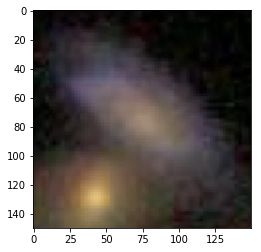

Sabc_5_10_48_587745541047321113.jpeg
SBabc : 45%   Sabc : 42%   S0 : 7%   SB0 : 3%   Edgeon : 0%   E3 : 0%   E7 : 0%   E0 : 0%   


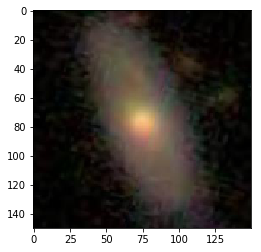

Sabc_5_9_41_587736941989134542.jpeg
Sabc : 44%   SBabc : 40%   S0 : 8%   SB0 : 6%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


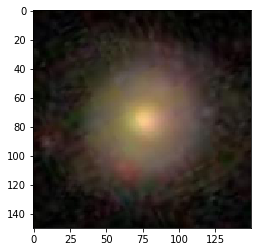

Sabc_7_9_42_587732578838184189.jpeg
SBabc : 37%   Sabc : 35%   S0 : 14%   SB0 : 10%   Edgeon : 1%   E3 : 0%   E7 : 0%   E0 : 0%   


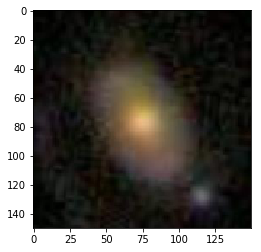

Sabc_6_7_58_588848899922198676.jpeg
SBabc : 50%   Sabc : 47%   S0 : 1%   SB0 : 0%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


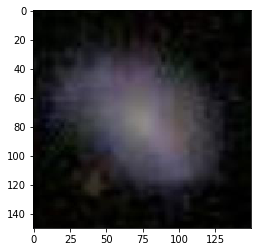

Sabc_4_9_57_587732702327537842.jpeg
Sabc : 55%   SBabc : 41%   S0 : 1%   SB0 : 0%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


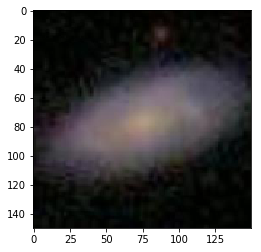

Sabc_5_13_39_587732048413196371.jpeg
Sabc : 79%   SBabc : 19%   S0 : 0%   SB0 : 0%   E0 : 0%   E3 : 0%   Edgeon : 0%   E7 : 0%   


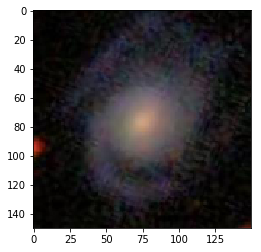

Sabc_6_7_51_587728932420059267.jpeg
S0 : 52%   SB0 : 28%   SBabc : 11%   Sabc : 8%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


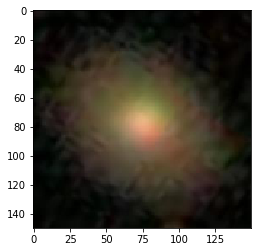

Sabc_7_9_41_588017704561475866.jpeg
S0 : 50%   SB0 : 29%   SBabc : 10%   Sabc : 8%   Edgeon : 0%   E0 : 0%   E3 : 0%   E7 : 0%   


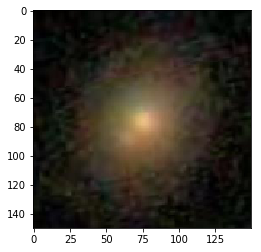

Sabc_6_11_45_587729778526519531.jpeg
SBabc : 50%   Sabc : 26%   SB0 : 12%   S0 : 10%   Edgeon : 0%   E3 : 0%   E0 : 0%   E7 : 0%   


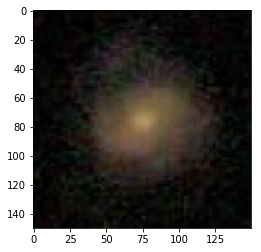

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image

#クラス予測サンプリング数
sample_size = 10

class_indices_dict = test_generator.class_indices
print(class_indices_dict)

class_list = list(class_indices_dict.keys())

for class_name in class_list:
    prediction_fnames_series = pd.Series(np.array(os.listdir(test_generator_directory + '/' + class_name)))
    prediction_fnames_selected = prediction_fnames_series.sample(n=sample_size).values
    
    for prediction_fname in prediction_fnames_selected:
        print(prediction_fname)
        prediction_img = load_img(test_generator_directory + '/' + class_name + '/' + prediction_fname, target_size = (150,150))
        prediction_arr = img_to_array(prediction_img)
        prediction_arr /= 255.0
        input_arr = prediction_arr.reshape(1,150,150,3)
        probs = model.predict(input_arr)[0]
        probs_series_sorted = pd.Series(probs, index = class_list).sort_values(ascending=False)
        #print(probs_series_sorted.index)
        #print(probs_series_sorted)
        prediction_results = ''
        for class_index in probs_series_sorted.index:
            prediction_results += class_index + ' : ' + str(int(probs_series_sorted[class_index] * 100)) + '%' + '   ' 
            #prediction_results_list = prediction_results_list.append(prediction_results)                                             
            
        print(prediction_results)                                              
        plt.imshow(input_arr[0])
        plt.show()
        